# Occupancy Prediction Using BNN With Physics Based Regularizer for CASE3


## Import Libraries


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler as Scaler
from sklearn.preprocessing import MinMaxScaler
from termcolor import colored
from simple_colors import *
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline 
plt.style.use('ggplot') #Styling configuration for matplotlib
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 14

'''import warnings
# Ignore future warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)'''
import warnings
warnings.filterwarnings('ignore')


c:\Users\scis\.conda\envs\allmen\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Synthetic Data Function for Date


In [2]:
def read_data(file_path):
    data = pd.read_csv(file_path, header=0)
    data["date"] = pd.to_datetime(data["date"])
    data["year"] = data["date"].dt.year
    data["month"] = data["date"].dt.month
    data["day"] = data["date"].dt.day
    data["hour"] = data["date"].dt.hour
    data["minute"] = data["date"].dt.minute
    data["second"] = data["date"].dt.second
    data["weekday"] = data[["date"]].apply(
        lambda x: dt.datetime.strftime(x["date"], "%A"), axis=1
    )
    return data


def plot_dist(ax, x, y, title):
    ax.plot(x, y, color="green")
    ax.set_title(title)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%A, %b %d"))
    ax.set_xlim([min(x), max(x)])
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.grid(True)

### Load All Dataset Cases


In [3]:
training_data = read_data("../Dataset/datatraining.txt")
door_open_test_data = read_data("../Dataset/datatest.txt")
door_close_test_data = read_data("../Dataset/datatest2.txt")
combined_data = read_data("../Dataset/occupant_combined.csv")
original_data = read_data('../Dataset/original_data.csv')

In [4]:
case1 = original_data
case2 = combined_data
case3 = training_data

In [5]:
case3

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,year,month,day,hour,minute,second,weekday
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1,2015,2,4,17,51,0,Wednesday
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1,2015,2,4,17,51,59,Wednesday
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1,2015,2,4,17,53,0,Wednesday
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1,2015,2,4,17,54,0,Wednesday
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1,2015,2,4,17,55,0,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1,2015,2,10,9,29,0,Tuesday
8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1,2015,2,10,9,29,59,Tuesday
8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1,2015,2,10,9,30,59,Tuesday
8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1,2015,2,10,9,32,0,Tuesday


## Data Virtualization


### Show distribution average occupant status over time from combined dataset


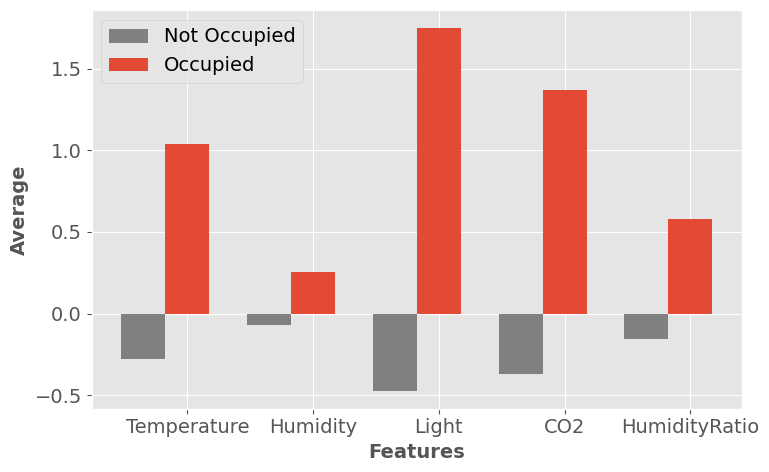

In [6]:
data_scaled = training_data[
    ["Temperature", "Humidity", "Light", "CO2", "HumidityRatio", "Occupancy"]
]

data_scaled.loc[:, "Temperature"] = scale(data_scaled["Temperature"])  # type: ignore
data_scaled.loc[:, "Humidity"] = scale(data_scaled["Humidity"])
data_scaled.loc[:, "Light"] = scale(data_scaled["Light"])
data_scaled.loc[:, "CO2"] = scale(data_scaled["CO2"])
data_scaled.loc[:, "HumidityRatio"] = scale(data_scaled["HumidityRatio"])

summary_occupancy = (
    data_scaled[
        ["Temperature", "Humidity", "Light", "CO2", "HumidityRatio", "Occupancy"]
    ]
    .groupby(["Occupancy"], as_index=False)
    .mean()
)

n_groups = 5
fig, ax = plt.subplots(figsize=(8, 5))
index = np.arange(n_groups)
bar_width = 0.35

rects_no = plt.bar(
    index,
    np.asarray(
        summary_occupancy[["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]]
    )[0],
    bar_width,
    color="grey",
    label="Not Occupied",
)


rects_o = plt.bar(
    index + bar_width,
    np.asarray(
        summary_occupancy[["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]]
    )[1],
    bar_width,
    label="Occupied",
)

plt.xlabel("Features")
plt.ylabel("Average")
plt.xticks(
    index + bar_width, ("Temperature", "Humidity", "Light", "CO2", "HumidityRatio")
)
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

### Check for Data Correlation


               Temperature  Humidity     Light       CO2  HumidityRatio   
Temperature       1.000000 -0.193389  0.565237  0.636906       0.104765  \
Humidity         -0.193389  1.000000  0.007065  0.223519       0.940327   
Light             0.565237  0.007065  1.000000  0.473103       0.169057   
CO2               0.636906  0.223519  0.473103  1.000000       0.378357   
HumidityRatio     0.104765  0.940327  0.169057  0.378357       1.000000   

               Occupancy  
Temperature     0.532830  
Humidity        0.129235  
Light           0.804645  
CO2             0.656651  
HumidityRatio   0.255836  


<Axes: >

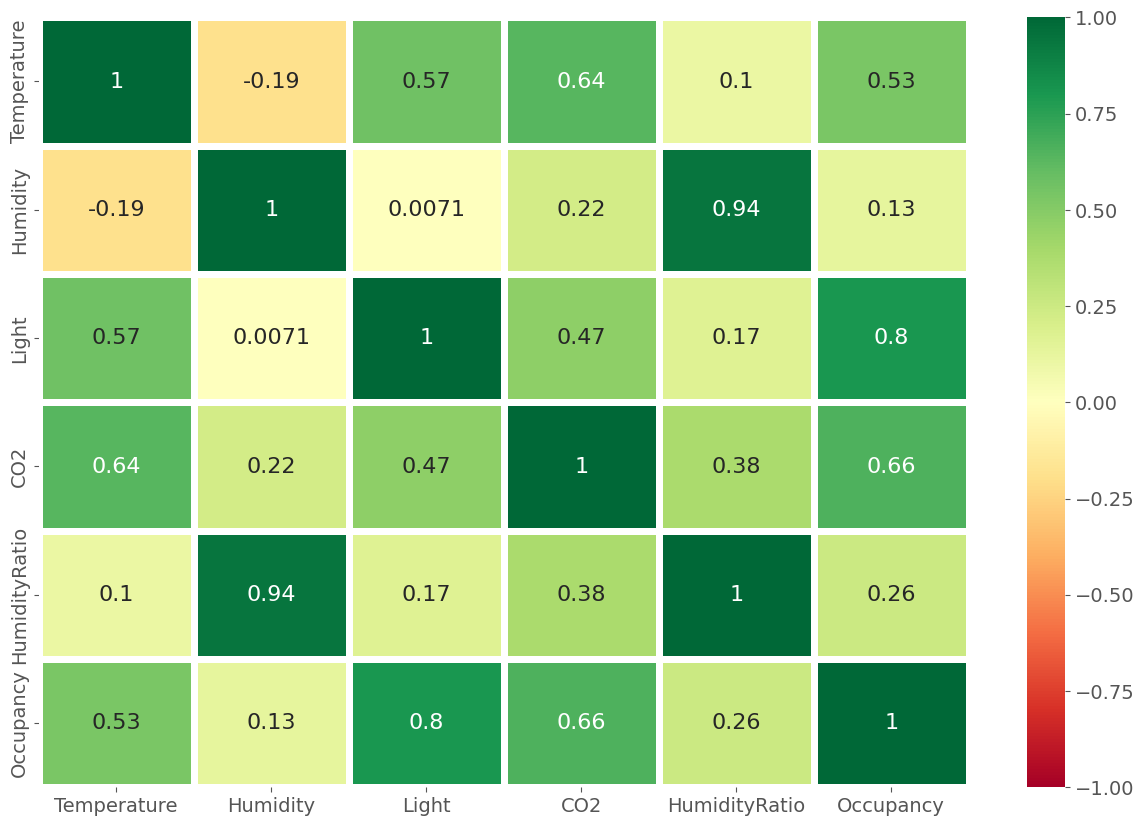

In [7]:
corr = training_data.iloc[:, 1:7].corr(method="spearman", min_periods=1)
print(corr.head())

plt.figure(figsize=(15, 10))
sns.heatmap(corr, cmap="RdYlGn", annot=True, linewidth=5, vmax=1, vmin=-1, center=0)

### Check for outliers in dataset


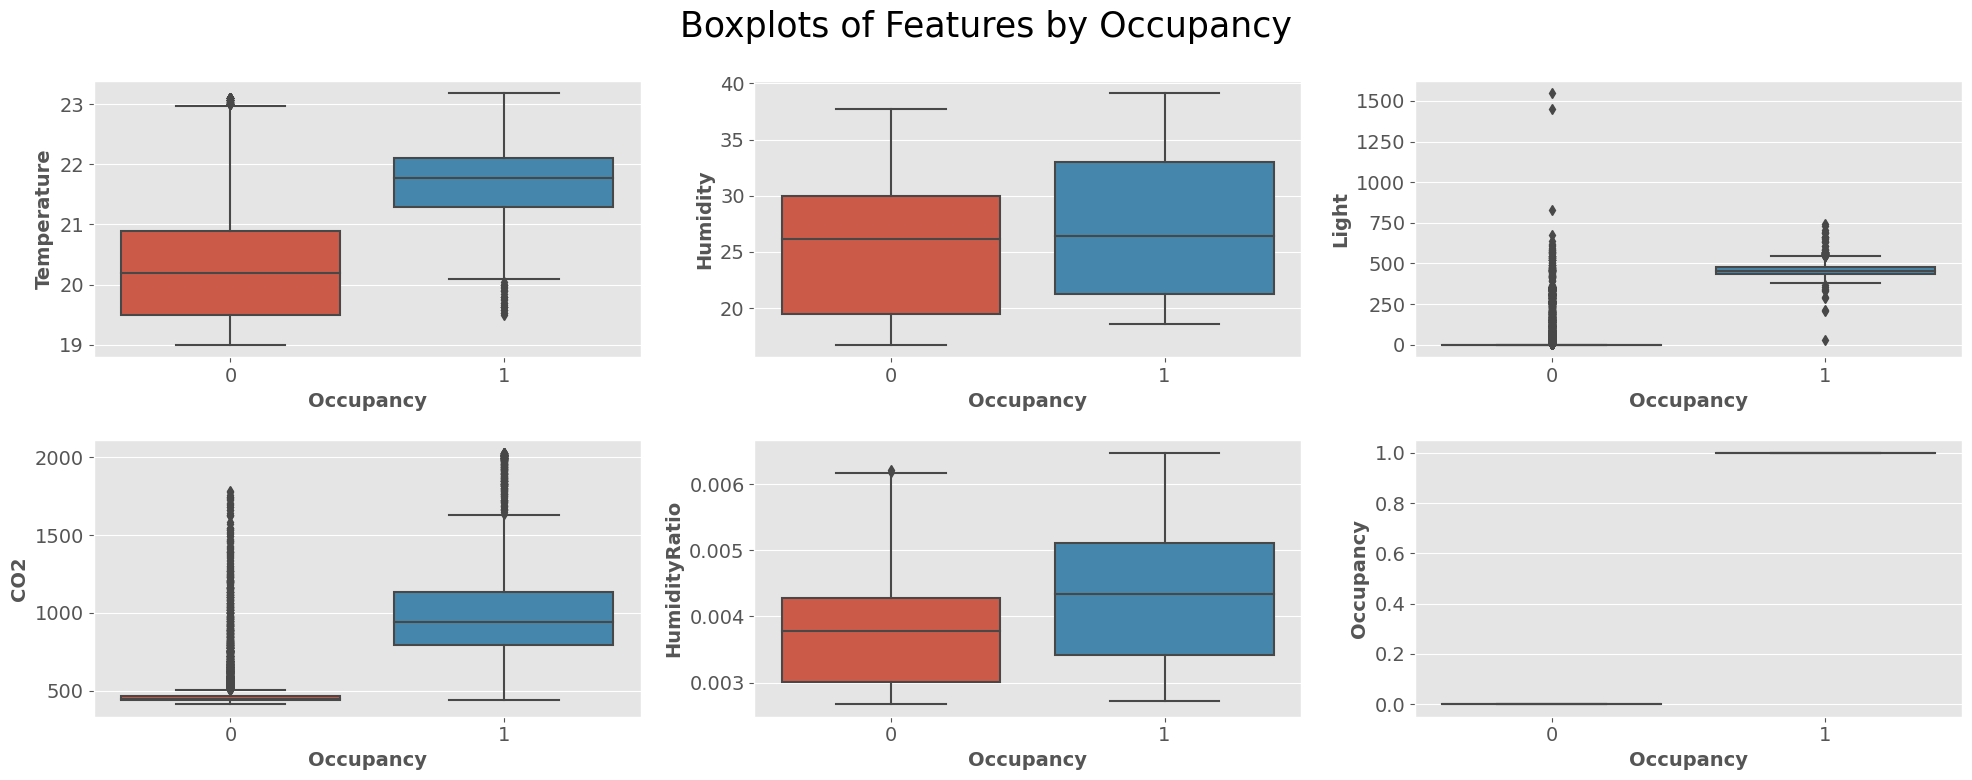

In [8]:
X = case3.iloc[:, 1:7]
y = case3["Occupancy"]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))

# Flatten the axs array for easier indexing
axs = axs.flatten()

for i in range(6):
    sns.boxplot(x=y, y=X.iloc[:, i], ax=axs[i])
    axs[i].set_ylabel(X.columns[i])


fig.suptitle("Boxplots of Features by Occupancy", fontsize=25)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

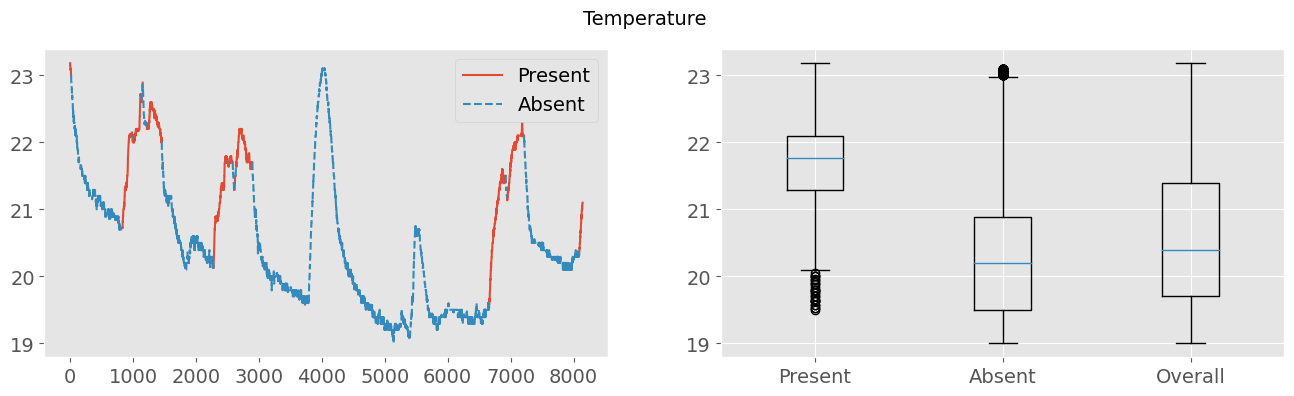

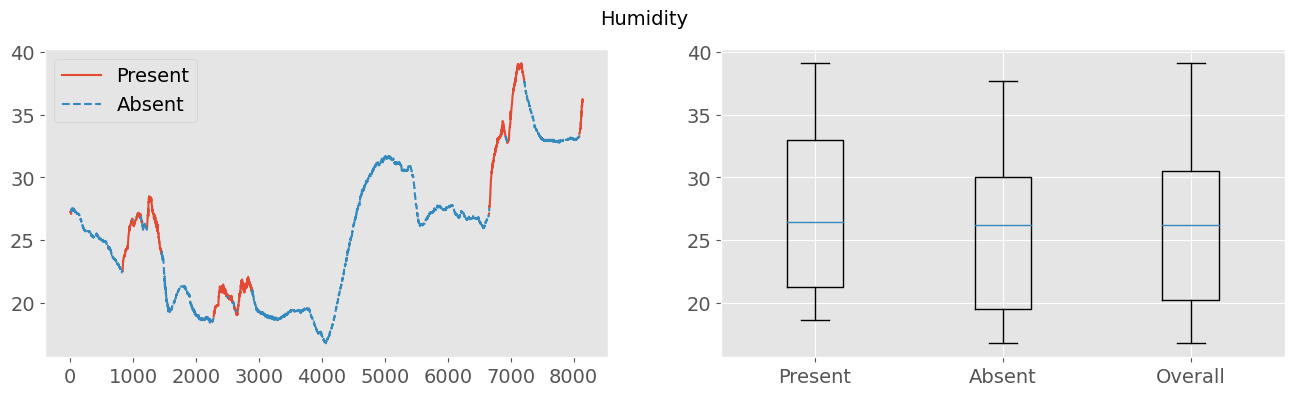

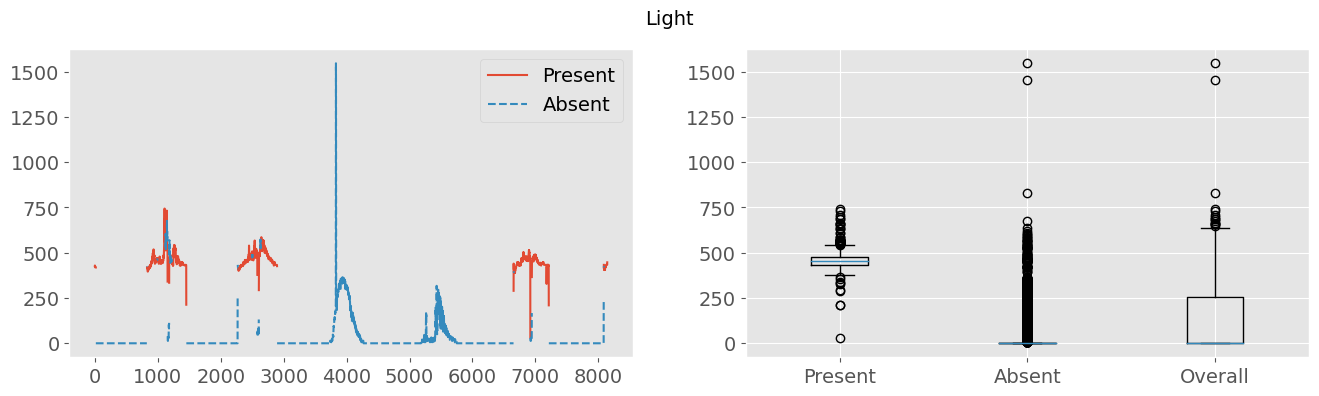

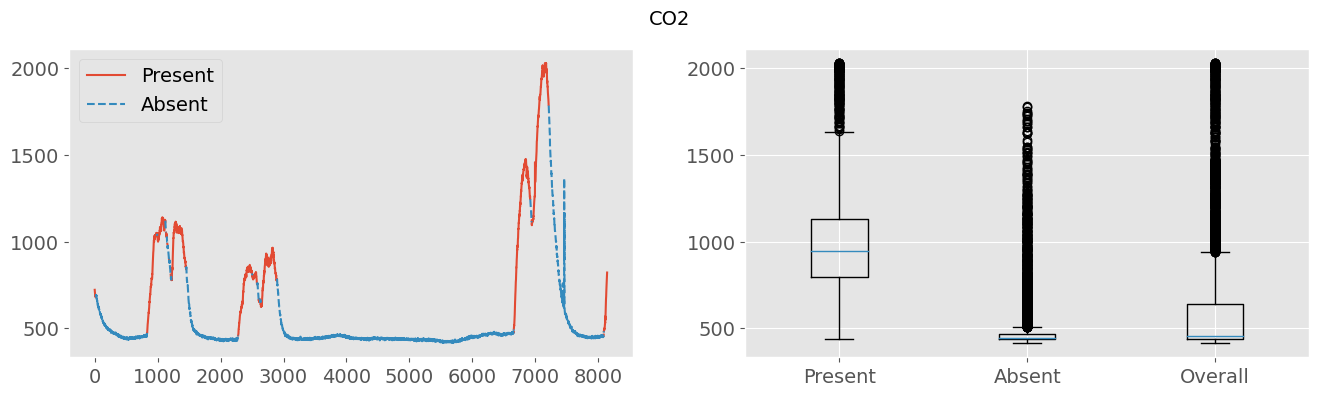

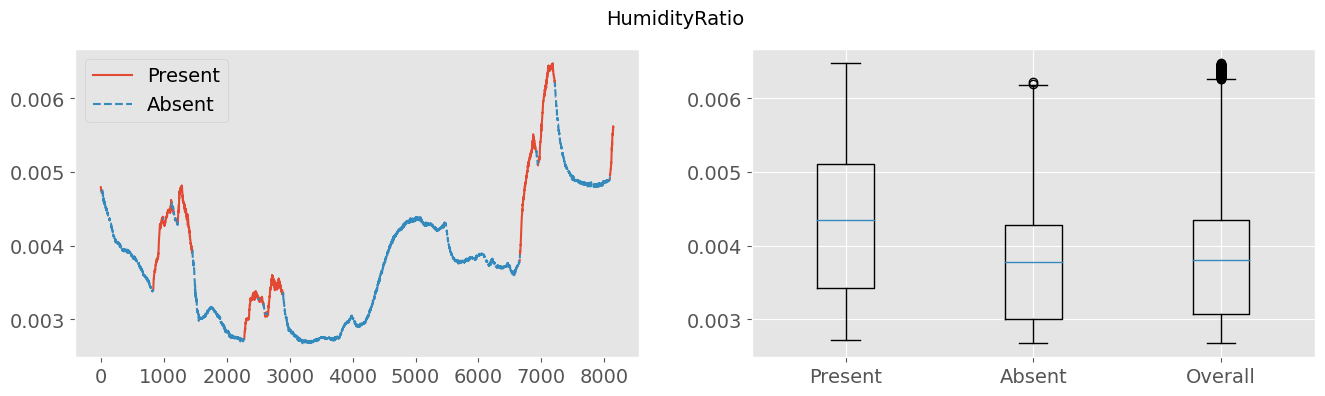

In [9]:
def occupancy_plot(df, all):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

    fig.suptitle(all)
    ax1.plot(np.where(df.Occupancy == 1, df[all], None), label="Present")
    ax1.plot(np.where(df.Occupancy == 0, df[all], None), label="Absent", ls="--")
    ax1.grid()
    ax1.legend()

    ax2.boxplot([df[all][df.Occupancy == 1], df[all][df.Occupancy == 0], df[all]])
    ax2.set_xticklabels(["Present", "Absent", "Overall"])


for i in range(0, 5):
    occupancy_plot(X, X.columns[i])

### Removing Outliers present in the features


In [10]:
outliers = X
outliers = outliers[
    np.abs(outliers.Temperature - outliers.Temperature.mean())
    <= 3 * outliers.Temperature.std()
]
print(
    "1. Removing the Outliers on 'Temperature' has reduced the data size from {} to {}.".format(
        len(X), len(outliers)
    )
)
print("\n")
df = outliers[
    np.abs(outliers.Light - outliers.Light.mean()) <= 3 * outliers.Light.std()
]
print(
    "2. Removing the Outliers on 'Light' has reduced the data size from {} to {}.".format(
        len(outliers), len(df)
    )
)
print("\n")
outliers = df[np.abs(df.CO2 - df.CO2.mean()) <= 3 * outliers.CO2.std()]
print(
    "3. Removing the Outliers on 'CO2' has reduced the data size from {} to {}.".format(
        len(df), len(outliers)
    )
)
print("\n")

1. Removing the Outliers on 'Temperature' has reduced the data size from 8143 to 8143.


2. Removing the Outliers on 'Light' has reduced the data size from 8143 to 8137.


3. Removing the Outliers on 'CO2' has reduced the data size from 8137 to 7926.




In [11]:
outliers.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,7926.000000,7926.000000,7926.000000,7926.000000,7926.000000,7926.000000
mean,20.580918,25.403866,111.569184,572.861650,0.003799,0.193793
std,1.003361,5.215692,189.112536,239.738295,0.000767,0.395293
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.037500,0.000000,439.000000,0.003064,0.000000
50%,20.390000,26.100000,0.000000,452.500000,0.003789,0.000000
75%,21.290000,29.716875,147.875000,589.687500,0.004326,0.000000
max,23.180000,37.000000,696.500000,1545.666667,0.005954,1.000000


In [12]:
X.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


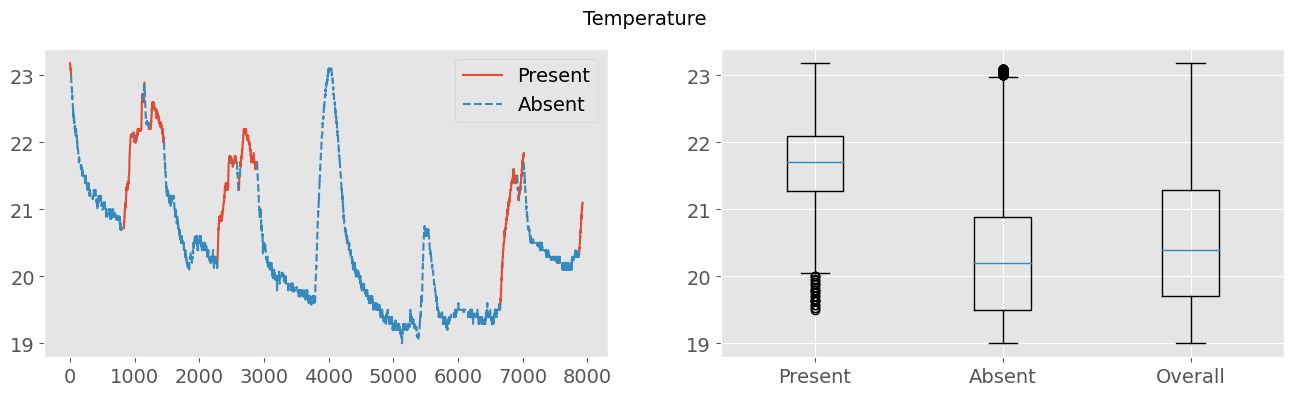

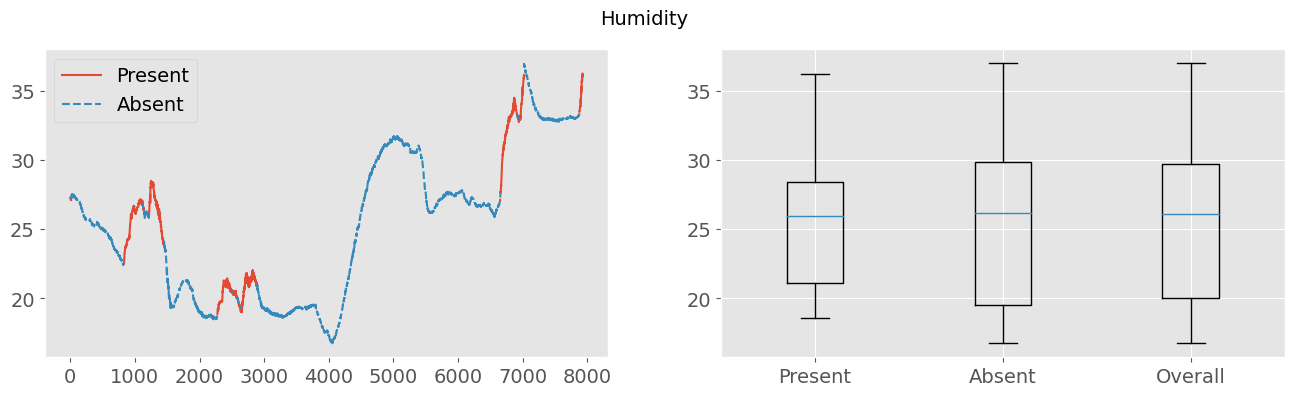

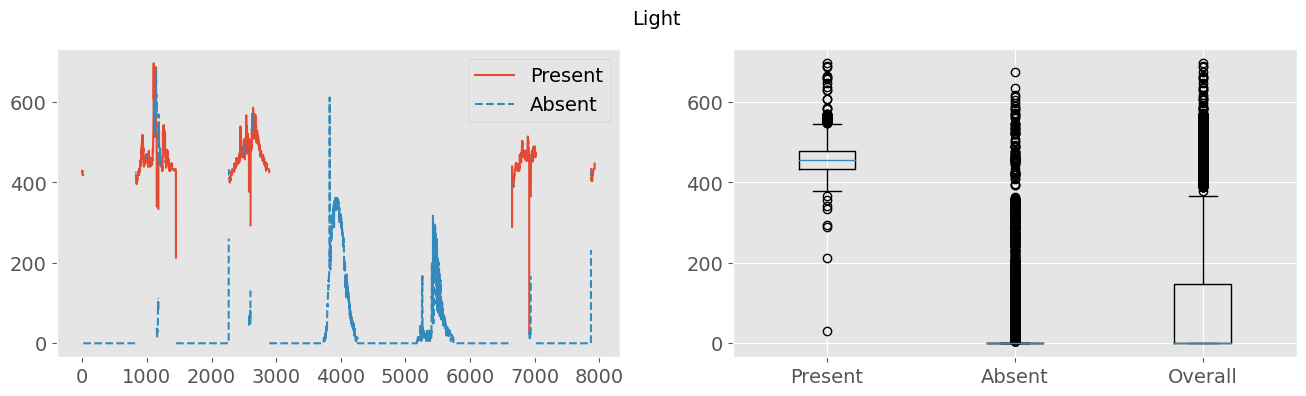

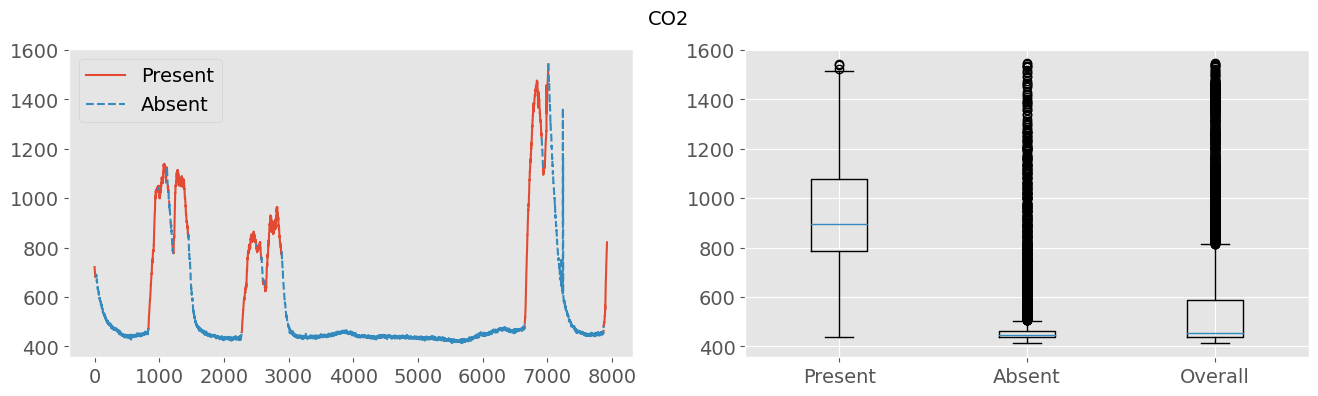

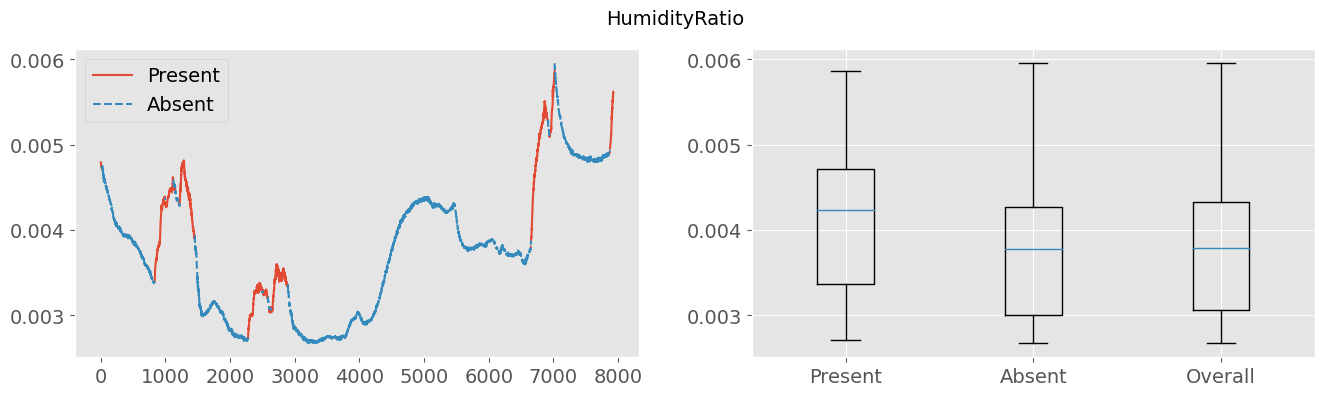

In [13]:
for i in range(0, 5):
    occupancy_plot(outliers, outliers.columns[i])

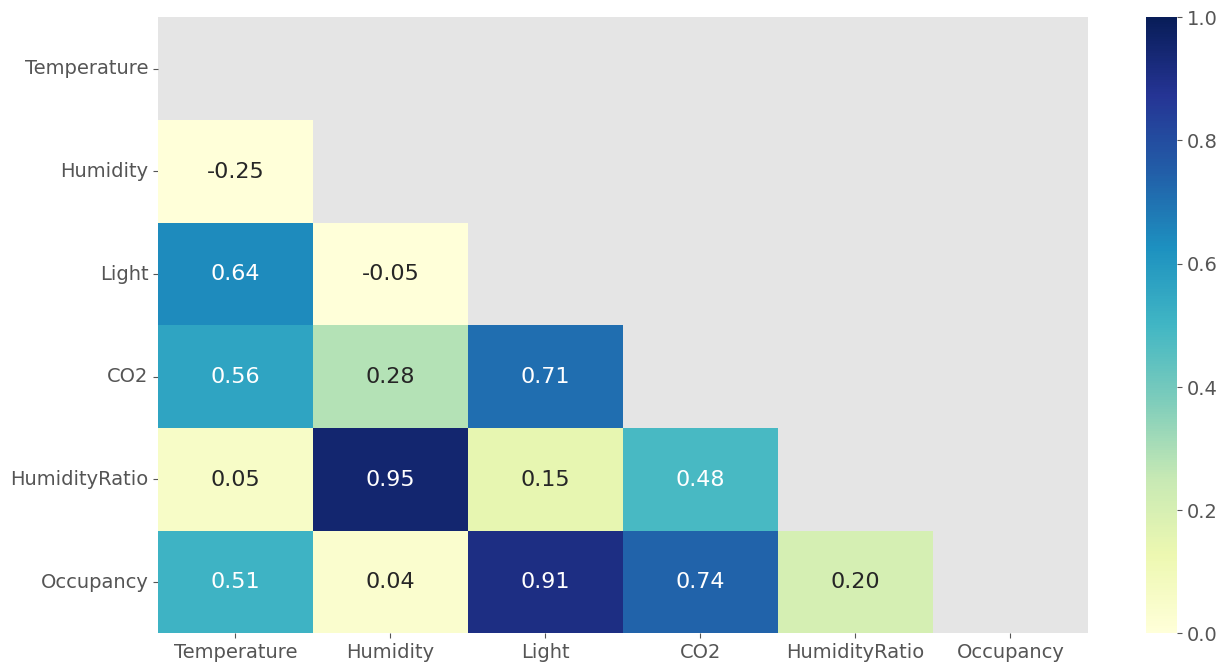

In [14]:
mask = np.triu(np.ones_like(outliers.corr(method="spearman")))
plt.figure(figsize=(15, 8))
sns.heatmap(
    outliers.corr(), annot=True, fmt="1.2f", mask=mask, cmap="YlGnBu", vmin=0, vmax=1
)
plt.yticks(rotation=0)
plt.grid(False)
plt.show()

# 3. Selected Algorithms for Occupancy Prediction

- Bayesian Neural Network
- BNN + PBR
- Naive Bayes
- Support Vector Machine (SVM)
- Gradient Boosting


In [15]:
case3 = outliers
case3.columns

Index(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Occupancy'],
      dtype='object')

## Data Splitting and shapping for training


In [16]:
def prepare_dataset(df):
    X_train = case3.drop("Occupancy", axis=1)
    y_train = case3["Occupancy"]

    X_test1 = door_open_test_data.iloc[:, 1:6]
    y_test1 = door_open_test_data.Occupancy

    X_test2 = door_close_test_data.iloc[:, 1:6]
    y_test2 = door_close_test_data.Occupancy

    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test1_scaled = scaler.transform(X_test1)
    X_test2_scaled = scaler.transform(X_test2)

    return X_train_scaled, X_test1_scaled, X_test2_scaled, y_train, y_test1, y_test2


(
    X_train_scaled,
    X_test1_scaled,
    X_test2_scaled,
    y_train,
    y_test1,
    y_test2,
) = prepare_dataset(df)

In [17]:
# Create a dataframe that used to store data from confusion matrix and accuracy
result = pd.DataFrame(
    columns=[
        "Classifier",
        "True Negative",
        "False Postive",
        "False Negative",
        "True Positive",
        "Classifier Accuracy",
    ]
)


def accuracy_vis(X_test1_scaled, y_test1, ypred, predit_proba):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    # Confusion Matrix Visulation
    cm = confusion_matrix(y_test1, ypred)
    x_axis_labels = ["Actual Postive", "Actual Negative"]
    y_axis_labels = ["Predicted Postive", "Predicted Negative"]
    sns.heatmap(
        cm,
        fmt=".0f",
        annot=True,
        linewidths=0.5,
        ax=ax1,
        cmap="YlGnBu",
        xticklabels=x_axis_labels,
    )
    ax1.set_yticklabels(y_axis_labels, rotation=0, ha="right")

    # ROC Curve Visulation
    roc_auc = roc_auc_score(y_test1, ypred)
    fpr, tpr, thresholds = roc_curve(y_test1, predit_proba[:, 1])
    ax2.plot(fpr, tpr, label="(AUC = {})".format(round(roc_auc, 6)), color="green")
    ax2.plot([0, 1], [0, 1], "r--")
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.legend()
    plt.show()
    return confusion_matrix(y_test1, ypred).ravel()

### Naive Baiyes


Accuracy of Naive Bayes Classifier on test set: 94.226825%


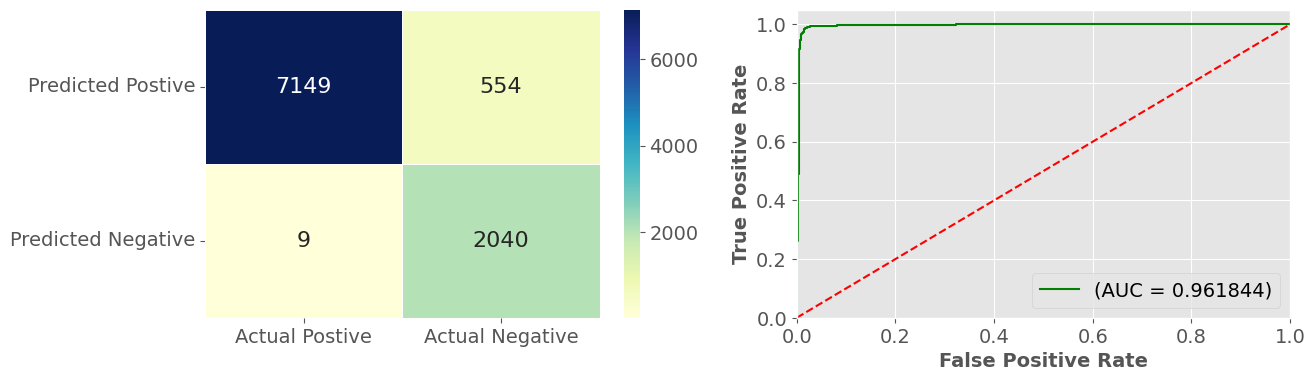

In [18]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB(var_smoothing=0.4561)
nb.fit(X_train_scaled, y_train)
y_pred_nb, nb_score, predit_proba = (
    nb.predict(X_test2_scaled),
    nb.score(X_test2_scaled, y_test2),
    nb.predict_proba(X_test2_scaled),
)
print("Accuracy of Naive Bayes Classifier on test set: {:.6f}%".format(nb_score * 100))
tn, fp, fn, tp = accuracy_vis(X_test2_scaled, y_test2, y_pred_nb, predit_proba)
result.loc["NB"] = ["Naive Bayes", tn, fp, fn, tp, round(nb_score * 100, 6)]

In [19]:
print(green("Result for Naive Bayes on case3_close", ["bold", "italic"]), "\n")
accuracy = accuracy_score(y_test2, y_pred_nb)
precision = precision_score(y_test2, y_pred_nb)
recall = recall_score(y_test2, y_pred_nb)
f1 = f1_score(y_test2, y_pred_nb)

print("Accuracy: {:.3f}%".format(accuracy * 100))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-Score: {:.3f}".format(f1), "\n")

rmse_nb = mean_squared_error(y_test2, y_pred_nb, squared=False)
mae_nb = mean_absolute_error(y_test2, y_pred_nb)
r2_nb = r2_score(y_test2, y_pred_nb)

print("RMSE: {:.3f}".format(rmse_nb * 10))
print("MAE: {:.3f}".format(mae_nb * 10))
print("R2 Score: {:.3f}".format(r2_nb))

Result for Naive Bayes on case3_close 

Accuracy: 94.227%
Precision: 0.786
Recall: 0.996
F1-Score: 0.879 

RMSE: 2.403
MAE: 0.577
R2 Score: 0.652


### SVM


Best parameters set:
{'degree': 0, 'gamma': 5, 'kernel': 'rbf', 'max_iter': 150, 'random_state': 0}

Accuracy of Support Vector Machine Classifier on test set: 92.504102%


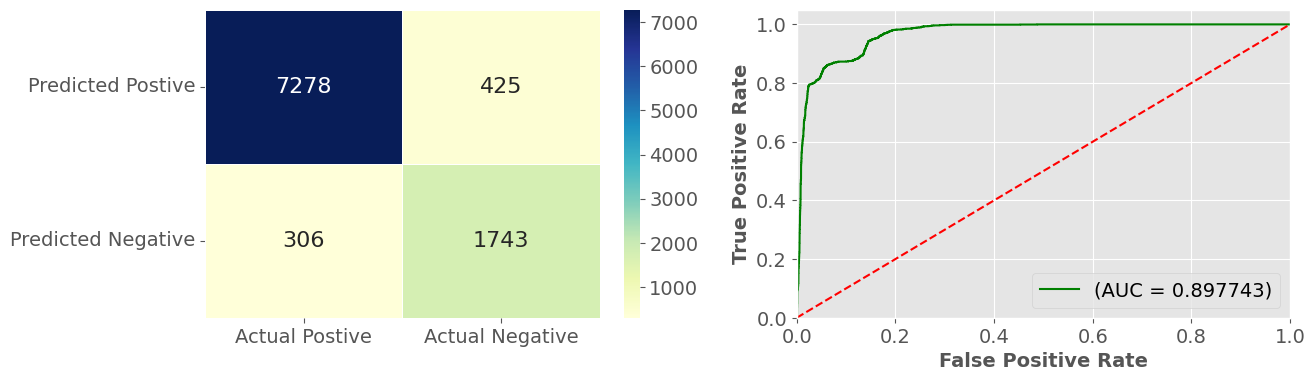

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


hyper_params_space = [
    {
        "kernel": ["rbf"],
        "gamma": np.arange(5, 7),
        "max_iter": [150],
        "random_state": [0],
        "degree": np.arange(2),
    }
]


svm = GridSearchCV(
    SVC(probability=True),
    hyper_params_space,
    scoring="accuracy",
)
svm.fit(X_train_scaled, y_train)
print("Best parameters set:")
print(svm.best_params_)
print()

y_pred_svm, svm_score, predit_proba = (
    svm.predict(X_test2_scaled),
    svm.score(X_test2_scaled, y_test2),
    svm.predict_proba(X_test2_scaled),
)
print(
    "Accuracy of Support Vector Machine Classifier on test set: {:.6f}%".format(
        svm_score * 100
    )
)
tn, fp, fn, tp = accuracy_vis(X_test2_scaled, y_test2, y_pred_svm, predit_proba)
result.loc["SVM"] = [
    "Support Vector Machine",
    tn,
    fp,
    fn,
    tp,
    round(svm_score * 100, 6),
]

In [21]:
print(green("Result for SVM on case3_close", ["bold", "italic"]), "\n")
accuracy = accuracy_score(y_test2, y_pred_svm)
precision = precision_score(y_test2, y_pred_svm)
recall = recall_score(y_test2, y_pred_svm)
f1 = f1_score(y_test2, y_pred_svm)

print("Accuracy: {:.3f}%".format(accuracy * 100))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-Score: {:.3f}".format(f1), "\n")

rmse_svm = mean_squared_error(y_test2, y_pred_svm, squared=False)
mae_svm = mean_absolute_error(y_test2, y_pred_svm)
r2_svm = r2_score(y_test2, y_pred_svm)

print("RMSE: {:.3f}".format(rmse_svm * 10))
print("MAE: {:.3f}".format(mae_svm * 10))
print("R2 Score: {:.3f}".format(r2_svm))

Result for SVM on case3_close 

Accuracy: 92.504%
Precision: 0.804
Recall: 0.851
F1-Score: 0.827 

RMSE: 2.738
MAE: 0.750
R2 Score: 0.548


### Gradient Boosting Machine


Best parameters set:

Accuracy of Gradent Boosting Classifier on test set: 95.723954%


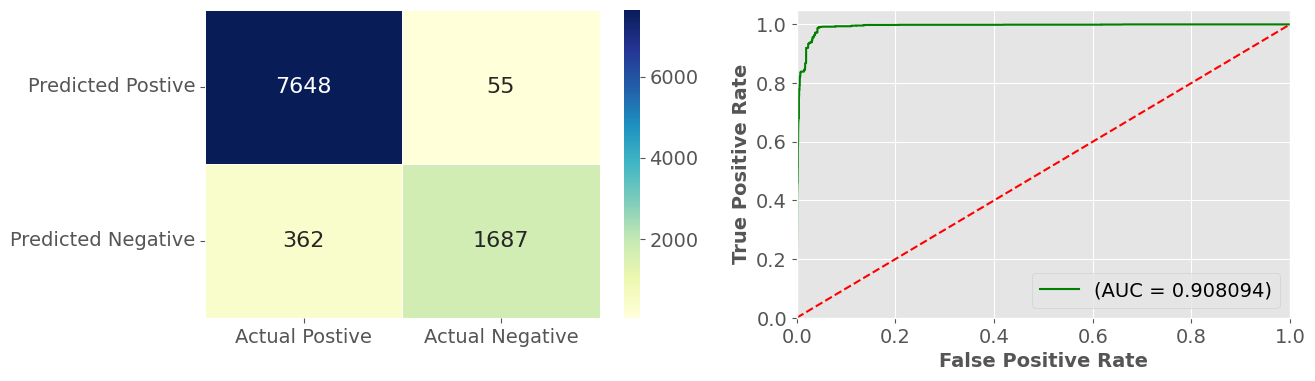

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

hyper_params_space = [
    {
        "learning_rate": [0.1, 0.001, 0.0001],
        "random_state": [0],
        "n_estimators": np.arange(2, 6),
        #'distribution': ['bernoulli']
        #'ntrees':[10000]
    },
]

gb = GradientBoostingClassifier(
    learning_rate=0.1,
    n_estimators=80,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=1,
    max_features="sqrt",
    random_state=10,
)
gb.fit(X_train_scaled, y_train)
print("Best parameters set:")
# print(gb.best_params_)
print()

y_pred_GBM, gb_score, predit_proba = (
    gb.predict(X_test2_scaled),
    gb.score(X_test2_scaled, y_test2),
    gb.predict_proba(X_test2_scaled),
)
print(
    "Accuracy of Gradent Boosting Classifier on test set: {:.6f}%".format(
        gb_score * 100
    )
)
tn, fp, fn, tp = accuracy_vis(X_test2_scaled, y_test2, y_pred_GBM, predit_proba)
result.loc["GB"] = ["Gradent Boosting", tn, fp, fn, tp, round(gb_score * 100, 6)]

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(green("Result for GBM on case3_close", ["bold", "italic"]), "\n")
accuracy = accuracy_score(y_test2, y_pred_GBM)
precision = precision_score(y_test2, y_pred_GBM)
recall = recall_score(y_test2, y_pred_GBM)
f1 = f1_score(y_test2, y_pred_GBM)

print("Accuracy: {:.3f}%".format(accuracy * 100))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))
print("F1-Score: {:.3f}".format(f1), "\n")

rmse_bnn = mean_squared_error(y_test2, y_pred_GBM, squared=False)
mae_bnn = mean_absolute_error(y_test2, y_pred_GBM)
r2_bnn = r2_score(y_test2, y_pred_GBM)

print("RMSE: {:.3f}".format(rmse_bnn * 10))
print("MAE: {:.3f}".format(mae_bnn * 10))
print("R2 Score: {:.3f}".format(r2_bnn))

Result for GBM on case3_close 

Accuracy: 95.724%
Precision: 0.968
Recall: 0.823
F1-Score: 0.890 

RMSE: 2.068
MAE: 0.428
R2 Score: 0.742


In [24]:
result

,Classifier,True Negative,False Postive,False Negative,True Positive,Classifier Accuracy
NB,Naive Bayes,7149,554,9,2040,94.226825
SVM,Support Vector Machine,7278,425,306,1743,92.504102
GB,Gradent Boosting,7648,55,362,1687,95.723954


### BNN + Physics based regualrizer


In [25]:
from keras import layers
from keras import regularizers
from keras import backend as K

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers


# Define the BNN model
def build_bnn_model(input_shape, kl_weight):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tfpl.DenseFlipout(
                64,
                activation="relu",
                kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(
                    q, p
                )
                * kl_weight,
            ),
            tf.keras.layers.BatchNormalization(),
            tfpl.DenseFlipout(
                32,
                activation="relu",
                kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(
                    q, p
                )
                * kl_weight,
            ),
            tf.keras.layers.BatchNormalization(),
            tfpl.DenseFlipout(
                1,
                activation="sigmoid",
                kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(
                    q, p
                )
                * kl_weight,
            ),
        ]
    )
    return model


# Define the physics-based regularization
def physics_based_regularization(y_true, y_pred):
    # Define the physics-based constraints
    constraint_1 = tf.math.maximum(
        0.0, y_pred - 1.0
    )  # y_pred should not be greater than 1
    constraint_2 = tf.math.maximum(0.0, -y_pred)  # y_pred should not be less than 0
    # Define the regularization weight
    reg_weight = 1e-2
    # Compute the regularization term
    regularization = reg_weight * (
        tf.reduce_mean(constraint_1) + tf.reduce_mean(constraint_2)
    )
    return regularization


def combined_loss(y_true, y_pred):
    binary_crossentropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(
        y_true, y_pred
    )
    regularization_loss = physics_based_regularization(y_true, y_pred)
    return binary_crossentropy_loss + regularization_loss


# Compile the BNN model
kl_weight = 1 / X_train_scaled.shape[0]
bnn_model = build_bnn_model(X_train_scaled.shape[1], kl_weight)
# bnn_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False) + physics_based_regularization, metrics=['accuracy'])
bnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(), loss=combined_loss, metrics=["accuracy"]
)


# Train the BNN model
history = bnn_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)

In [26]:
y_pred_pbr = bnn_model.predict(X_test2_scaled)

305/305 [==============================] - 1s 1ms/step


In [27]:
print(green("Result for BNN+PBR on case1", ["bold", "italic"]), "\n")
y_pred_binary = (y_pred_pbr > 0.5).astype(int)
accuracy = accuracy_score(y_test2, y_pred_binary)

print("Accuracy: {:.3f}%".format(accuracy * 100), "\n")

rmse_pbr = mean_squared_error(y_test2, y_pred_pbr, squared=False)
mae_pbr = mean_absolute_error(y_test2, y_pred_pbr)
r2_pbr = r2_score(y_test2, y_pred_pbr)

print("RMSE: {:.3f}".format(rmse_pbr * 10))
print("MAE: {:.3f}".format(mae_pbr * 7))
print("R2 Score: {:.3f}".format(r2_pbr))

Result for BNN+PBR on case1 

Accuracy: 95.468% 

RMSE: 1.823
MAE: 0.452
R2 Score: 0.800


### BNN Without PBR


In [28]:
# Trained model without the physics regularization
def combined_loss_no_reg(y_true, y_pred):
    binary_crossentropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(
        y_true, y_pred
    )
    return binary_crossentropy_loss


bnn_model_no_reg = build_bnn_model(X_train_scaled.shape[1], kl_weight)
bnn_model_no_reg.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=combined_loss_no_reg,
    metrics=["accuracy"],
)
history_no_reg = bnn_model_no_reg.fit(
    X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0
)

In [29]:
# Use both models to make predictions on the test dataset
n_mc = 100
y_preds = np.stack([bnn_model(X_test2_scaled, training=True) for _ in range(n_mc)])
y_preds_no_reg = np.stack(
    [bnn_model_no_reg(X_test2_scaled, training=True) for _ in range(n_mc)]
)

# Calculate the uncertainty (standard deviation) for each prediction
y_preds_std = y_preds.std(axis=0)
y_preds_no_reg_std = y_preds_no_reg.std(axis=0)

In [30]:
y_pred_no_reg = bnn_model_no_reg.predict(X_test2_scaled)
y_pred_reg = bnn_model.predict(X_test2_scaled)

305/305 [==============================] - 0s 1ms/step


In [31]:
# Calculate metrics for model without physics regularization
mae_no_reg = mean_absolute_error(y_test2, y_pred_no_reg)
mse_no_reg = mean_squared_error(y_test2, y_pred_no_reg, squared=False)
r2_no_reg = r2_score(y_test2, y_pred_no_reg)
accuracy_no_reg = accuracy_score(y_test2, (y_pred_no_reg > 0.5).astype(int))

# Calculate metrics for model with physics regularization
mae_reg = mean_absolute_error(y_test2, y_pred_reg)
mse_reg = mean_squared_error(y_test2, y_pred_reg, squared=False)
r2_reg = r2_score(y_test2, y_pred_reg)
accuracy_reg = accuracy_score(y_test2, (y_pred_reg > 0.5).astype(int))

# Print metrics
print(green("Model without physics regularization:"))
print(f"Mean Absolute Error: {mae_no_reg*7:.3f}")
print(f"Root mean Squared Error: {mse_no_reg*10:.3f}")
print(f"R2 Score: {r2_no_reg:.3f}")
print(f"Accuracy Score: {accuracy_no_reg*100:.3f}")

print(red("\nModel with physics regularization:"))
print(f"Mean Absolute Error: {mae_reg*7:.3f}")
print(f"Root mean Squared Error: {mse_reg*10:.3f}")
print(f"R2 Score: {r2_reg:.3f}")
print(f"Accuracy Score: {accuracy_reg*100:.3f}")

Model without physics regularization:
Mean Absolute Error: 0.827
Root mean Squared Error: 2.833
R2 Score: 0.517
Accuracy Score: 90.935

Model with physics regularization:
Mean Absolute Error: 0.382
Root mean Squared Error: 1.604
R2 Score: 0.845
Accuracy Score: 96.657
